# **Customer Churn Prediction for a Telecom Company GTC Project**

This notebook presents a complete machine learning project pipeline for predictingcustomer churn.

It includes data preparation, exploratory data analysis (EDA),
feature engineering, model training, and model evaluation.

# 1. Data Preparation


**Importing necessary libraries**

We'll use pandas for data manipulation, numpy for numerical operations,

scikit-learn for machine learning models and preprocessing,

and matplotlib/seaborn for visualizations.

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import pickle

**Loading the dataset**

The dataset used is the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file.
The `customerID` column is dropped as it is a unique identifier and not a predictive feature.

In [39]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop(['customerID'], axis=1)
#Show shape of the dataset
df.shape

(7043, 20)

In [40]:
#Show first 5 rows
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Handling Missing Values and Data Types**

We first inspect the data types and look for missing values.

In [41]:
print("Initial Data Info:")
print(df.info())
print("-" * 50)

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 

The `TotalCharges` column is of type object. We'll convert it to a numeric type.
The `errors='coerce'` argument will turn any non-numeric values into NaN.

In [42]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Upon conversion, we find missing values (NaNs). For this project, we will drop these rows.


In [43]:
print(df.isnull().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [44]:
df.dropna(inplace=True)
print("Data Info after cleaning:")
print(df.info())
print("-" * 50)

Data Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     703

In [45]:
#checking the distribution of churn column
print(df["Churn"].value_counts())

Churn
No     5163
Yes    1869
Name: count, dtype: int64


**Insights:**
1. Customer ID removed as it is not required for modelling
2. No missing values in the dataset
3. Missing values in the TotalCharges column were replaced with 0
4. Class imbalance identified in the target

# 2. Exploratory Data Analysis (EDA) and Feature Building

This section focuses on understanding the data and its relationship with churn.


In [46]:
df.shape

(7032, 20)

In [47]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [48]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [49]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


**Numerical Features - Analysis**

Understand the distribution of teh numerical features

In [50]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

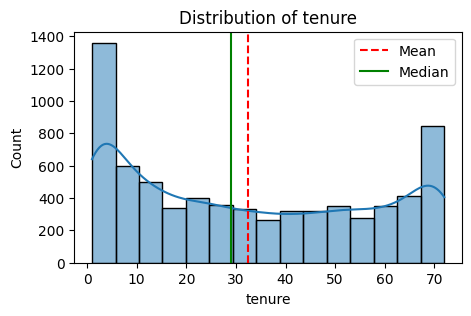

In [51]:
plot_histogram(df, "tenure")

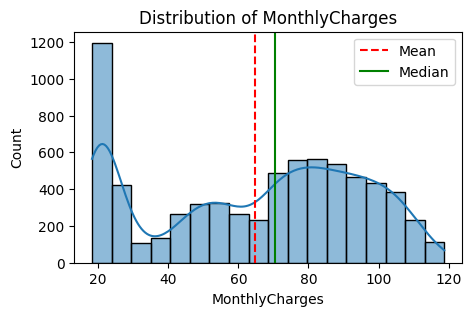

In [52]:
plot_histogram(df, "MonthlyCharges")

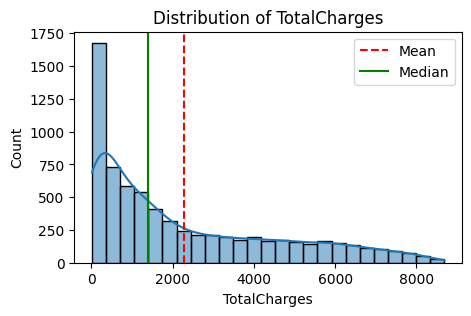

In [53]:
plot_histogram(df, "TotalCharges")

**Countplot for categorical columns**

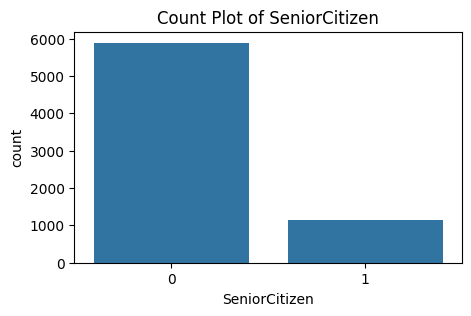

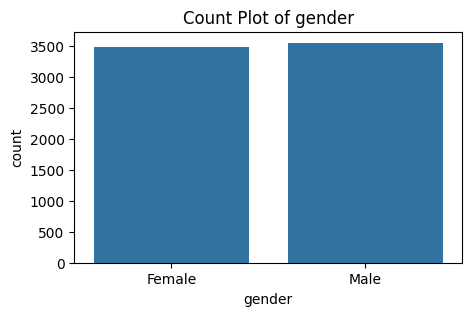

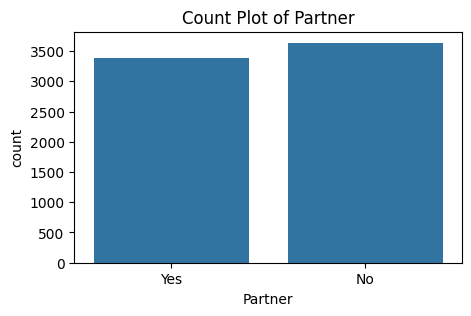

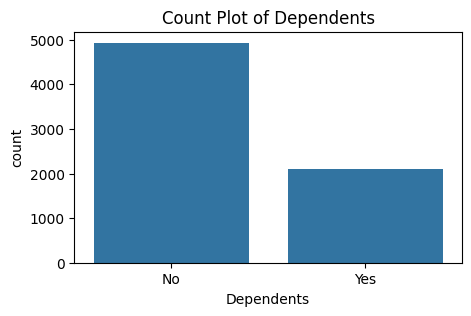

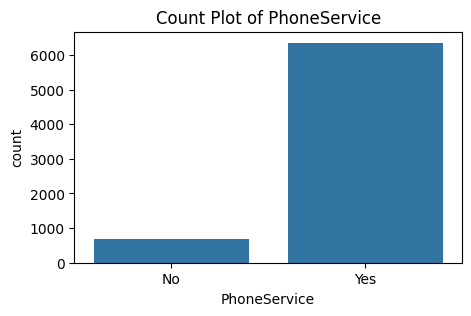

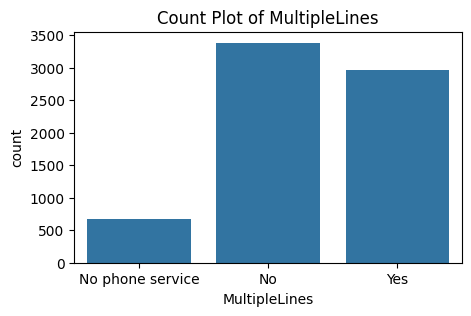

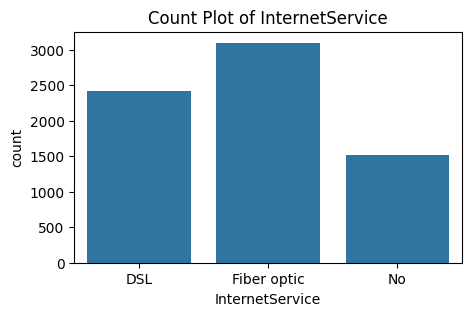

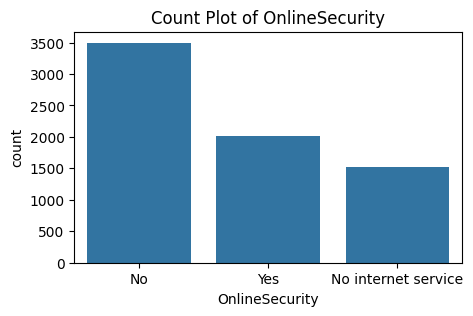

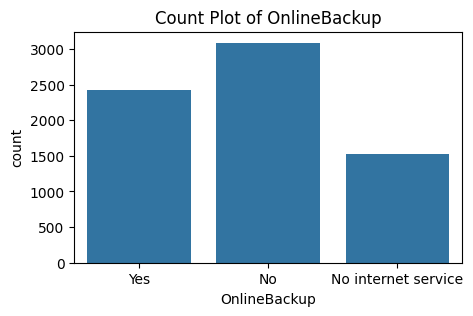

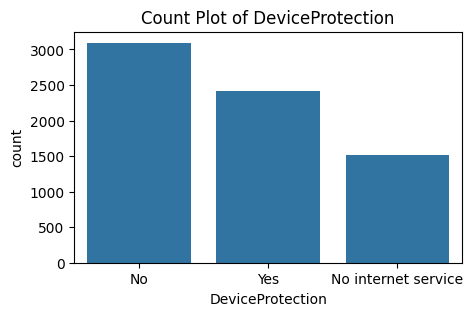

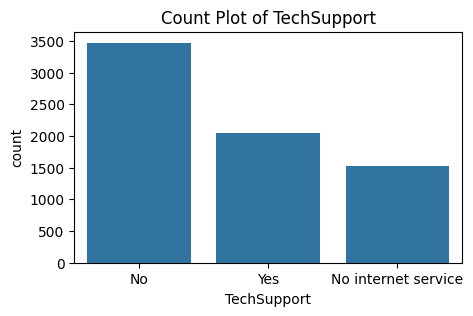

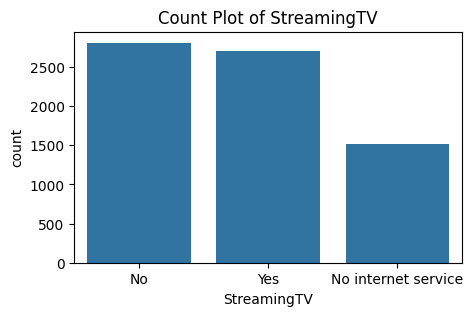

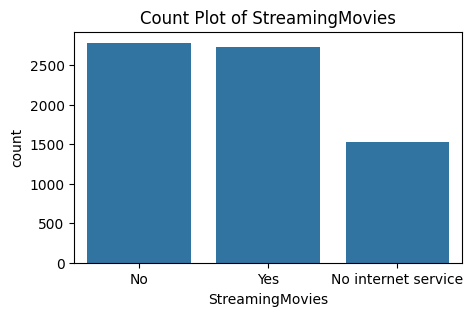

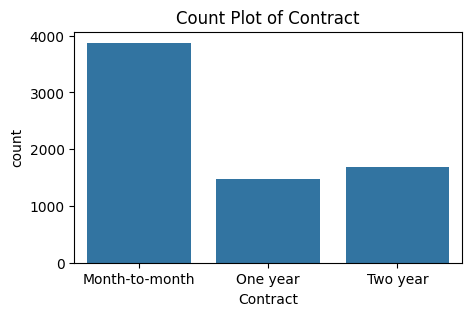

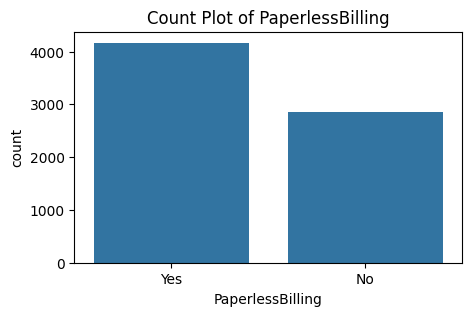

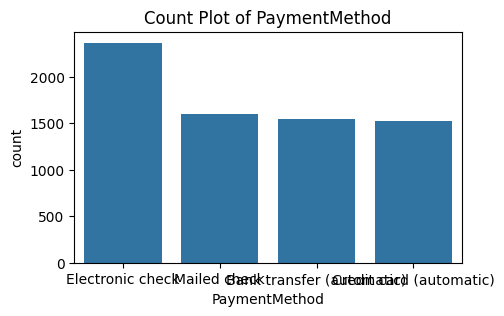

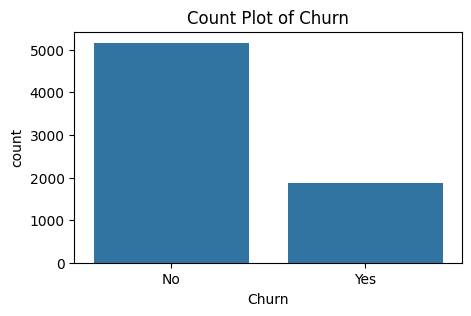

In [54]:
object_cols = df.select_dtypes(include="object").columns.to_list()

object_cols = ["SeniorCitizen"] + object_cols

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

**Churn Distribution by Contract Type**

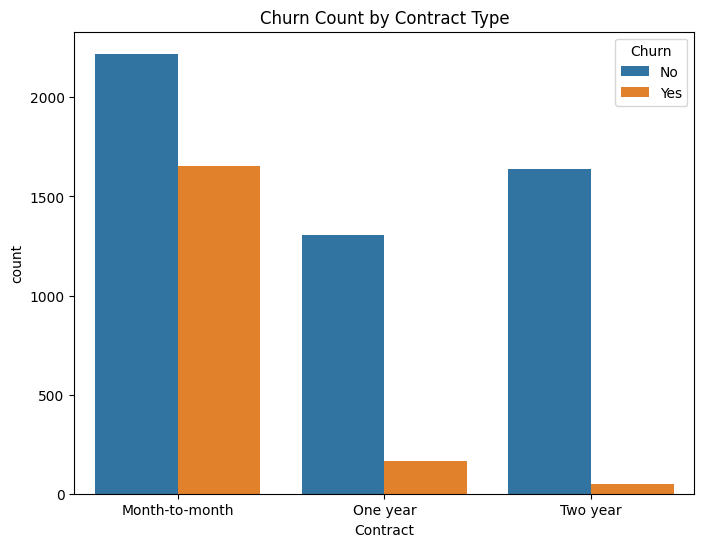

In [55]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn Count by Contract Type')
plt.show()

**Churn Distribution by Internet Service Type**

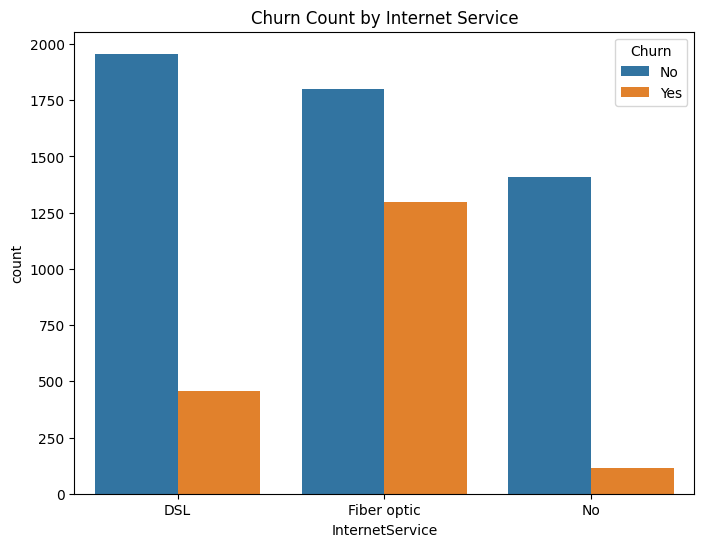

In [56]:
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn Count by Internet Service')
plt.show()

**Churn Distribution by Payment Method**

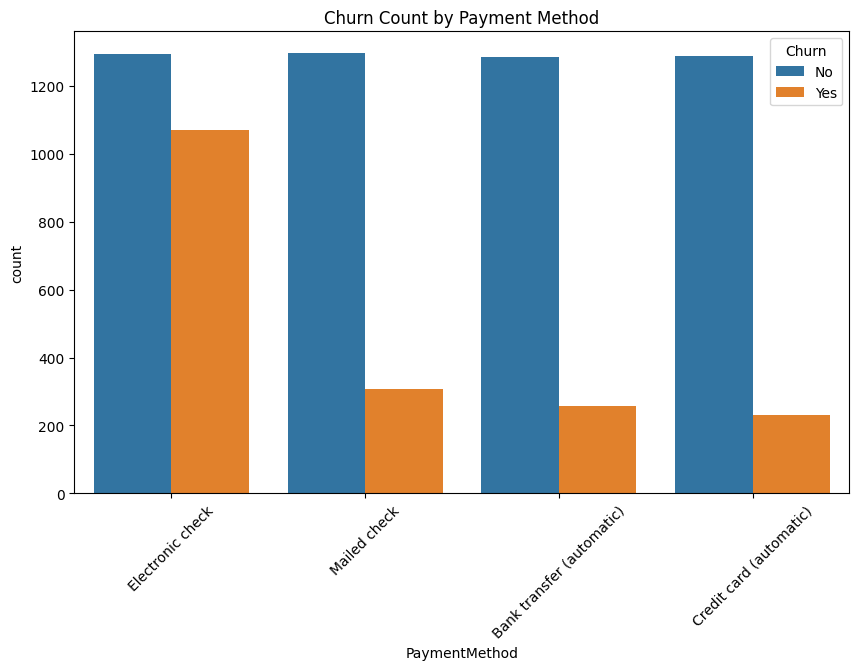

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Churn Count by Payment Method')
plt.xticks(rotation=45)
plt.show()

**Impact of Monthly Charges on Churn**

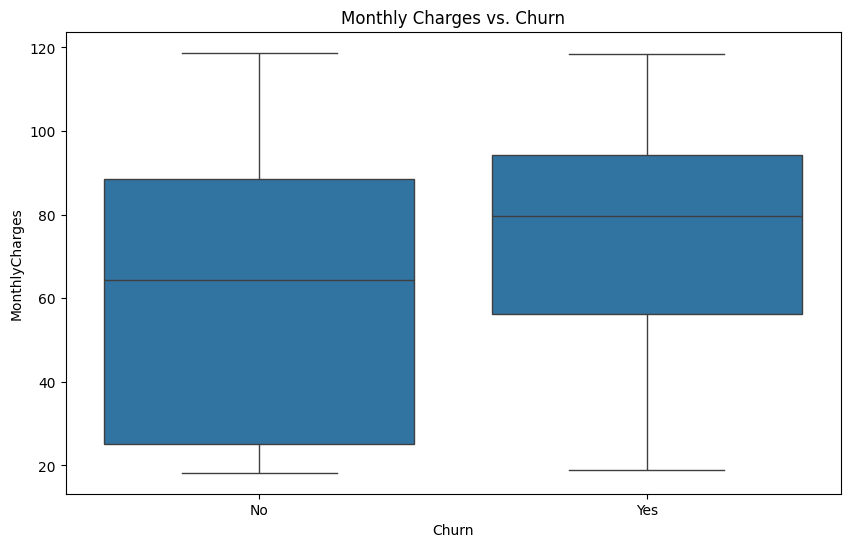

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs. Churn')
plt.show()

**Impact of Tenure on Churn**

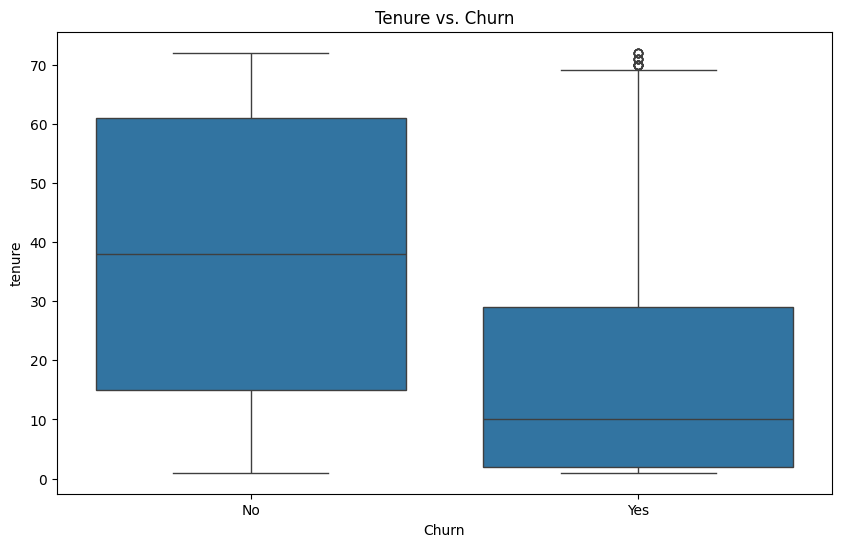

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs. Churn')
plt.show()

**Correlation Heatmap of Numerical Features**

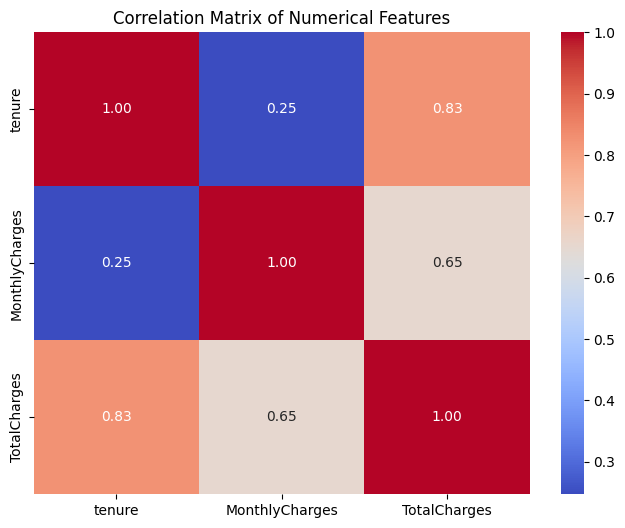

In [61]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Feature engineering to improve model's performance**

In [60]:
# Tenure groups
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '12-24', '24-48', '48-72'])

# Charges ratio (avoid division by zero)
df['ChargesRatio'] = np.where(df['MonthlyCharges'] > 0, df['TotalCharges'] / df['MonthlyCharges'], 0)

# Average monthly spend
df['AvgMonthlySpend'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], 0)

df[['tenure', 'TenureGroup', 'ChargesRatio', 'AvgMonthlySpend']].head()

,tenure,TenureGroup,ChargesRatio,AvgMonthlySpend
0,1,0-12,1.000000,29.850000
1,34,24-48,33.178227,55.573529
2,2,0-12,2.008357,54.075000
3,45,24-48,43.516548,40.905556
4,2,0-12,2.144979,75.825000


**Data Preprocessing**

In [62]:
#Label encoding of target column
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

/tmp/ipython-input-1384506168.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


In [63]:
print(df["Churn"].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64


Label encoding of categorical fetaures

In [64]:
# Identify categorical columns (object or category dtype)
object_columns = df.select_dtypes(include=["object", "category"]).columns
print("Categorical Columns:", object_columns.tolist())


Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']


In [65]:
# Initialize dictionary to save encoders
encoders = {}

# Apply Label Encoding
for column in object_columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column].astype(str))  # ensure string type
    encoders[column] = label_encoder

# Save the encoders for future use (important for deployment phase)
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder(),
 'TenureGroup': LabelEncoder()}

In [66]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,ChargesRatio,AvgMonthlySpend
0,0,0,1,0,1,0,1,0,0,2,...,0,0,1,2,29.85,29.85,0,0,1.000000,29.850000
1,1,0,0,0,34,1,0,0,2,0,...,0,1,0,3,56.95,1889.50,0,2,33.178227,55.573529
2,1,0,0,0,2,1,0,0,2,2,...,0,0,1,3,53.85,108.15,1,0,2.008357,54.075000
3,1,0,0,0,45,0,1,0,2,0,...,0,1,0,0,42.30,1840.75,0,2,43.516548,40.905556
4,0,0,0,0,2,1,0,1,0,0,...,0,0,1,2,70.70,151.65,1,0,2.144979,75.825000


**Splitting Data into Training and Testing Sets**

We split the data into training and testing sets with a 80/20 ratio.
`stratify=y` is used to ensure the same proportion of churners is present in both sets.

In [67]:
# splitting the features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [68]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (5625, 22) (5625,)
Shape of test data: (1407, 22) (1407,)


**Synthetic Minority Oversampling TEchnique (SMOTE)**

In [69]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(y_train_smote.shape)
print(y_train_smote.value_counts())

(8260,)
Churn
1    4130
0    4130
Name: count, dtype: int64


# 3. Training & Validation


**Step 1 - Define Models**



In [70]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}

**Step 2 - Train & Evaluate Models**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


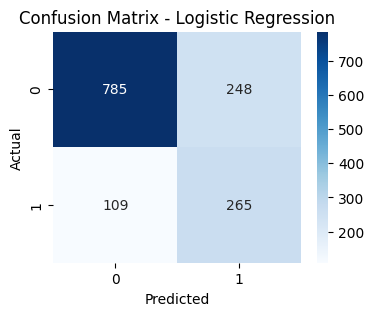

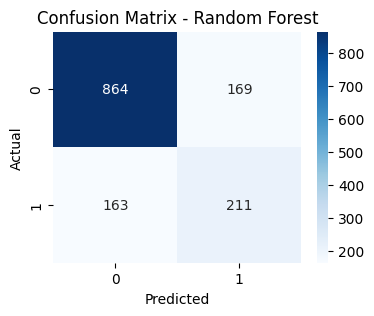

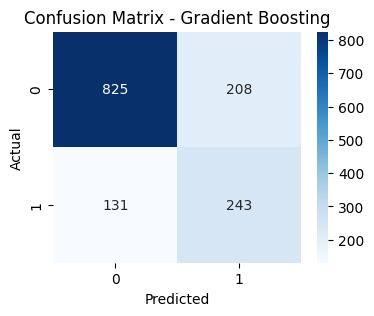

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:23:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


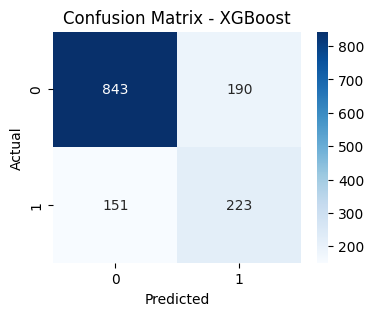

In [71]:
results = {}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)   # training on balanced data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

**Step 3 - ROC Curves**

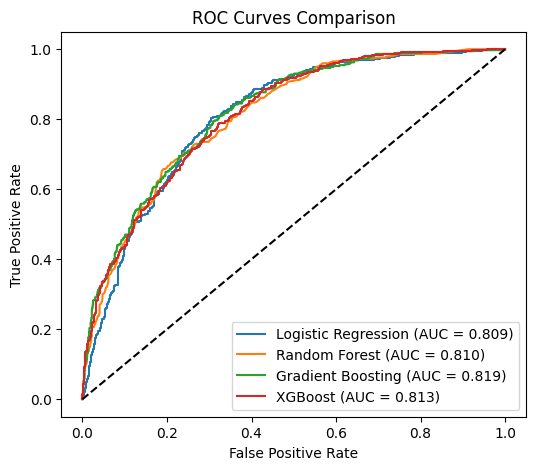

In [72]:
plt.figure(figsize=(6,5))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

**Step 4 - Results Summary**

In [73]:
results_df = pd.DataFrame(results).T
display(results_df.sort_values(by="ROC-AUC", ascending=False))

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Gradient Boosting,0.759062,0.538803,0.649733,0.589091,0.819479
XGBoost,0.757640,0.539952,0.596257,0.566709,0.812814
Random Forest,0.764037,0.555263,0.564171,0.559682,0.809889
Logistic Regression,0.746269,0.516569,0.708556,0.597520,0.808835


**Hyperparameter Tuning - Random Forest**

In [76]:
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, class_weight="balanced")

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf,
    n_iter=20, cv=3, scoring='accuracy',
    random_state=42, n_jobs=-1, verbose=2
)

random_search_rf.fit(X_train_smote, y_train_smote)

print("Best RF Params:", random_search_rf.best_params_)
print("Best RF Accuracy (CV):", random_search_rf.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best RF Accuracy (CV): 0.8288259817880504


**Hyperparameter Tuning - XGBoost**

In [77]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

random_search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist_xgb,
    n_iter=20, cv=3, scoring='accuracy',
    random_state=42, n_jobs=-1, verbose=2
)

random_search_xgb.fit(X_train_smote, y_train_smote)

print("Best XGB Params:", random_search_xgb.best_params_)
print("Best XGB Accuracy (CV):", random_search_xgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:31:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best XGB Accuracy (CV): 0.820109406406233


**Re-evaluate Best Models**

In [78]:
# Evaluate tuned models on test set
best_rf = random_search_rf.best_estimator_
best_xgb = random_search_xgb.best_estimator_

for name, model in {"Tuned Random Forest": best_rf, "Tuned XGBoost": best_xgb}.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {acc:.4f}")

Tuned Random Forest Test Accuracy: 0.7726
Tuned XGBoost Test Accuracy: 0.7605
